In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.hardwaremanager import HardwareManager
from hardware.pulser.pulser import OutputState, TriggerRearm, TriggerStart
from hardware import config as hcf

import numpy as np
import matplotlib.pyplot as plt
import calibration.setting as clb

In [2]:
from logmodule import setup_logging
setup_logging()
import logging
logger = logging.getLogger(__name__)

In [3]:
hw = HardwareManager()
hw.add_default_hardware()

2025-08-15 10:00:02 INFO hardwaremanager MainThread: Added 'camera' for Thorlabs Camera with address <hardware.camera.thorlabs.CameraController object at 0x000001E3F5429CC0>
2025-08-15 10:00:02 INFO hardwaremanager MainThread: Added 'uf' for Microfluidics Pnuematic Control added with address PneumaticControl 192.168.1.3:502
2025-08-15 10:00:02 INFO windfreakcontrol ThreadPoolExecutor-0_1: Connected to Windfreak SynthHD on COM4
2025-08-15 10:00:02 INFO hardwaremanager MainThread: Added 'windfreak' for Windfreak Synth with address <hardware.mw.windfreakcontrol.WindfreakSynth object at 0x000001E3F542A440>
2025-08-15 10:00:02 INFO pulser ThreadPoolExecutor-0_4: Stream Sequence with 1 runs
2025-08-15 10:00:02 INFO pulser ThreadPoolExecutor-0_4: Reset Pulse Streamer
2025-08-15 10:00:02 INFO hardwaremanager MainThread: Added 'pg' for Pulse Streamer with address <hardware.pulser.pulser.PulseGenerator object at 0x000001E3F542B520>


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 169.254.8.2
VDI Sythesizer Serail Port Open
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


2025-08-15 10:00:02 INFO hardwaremanager MainThread: Added 'whitelight' for WhiteLight on channel /Dev1/ao0 with address <hardware.camera.light.WhiteLight object at 0x000001E3F546C250>
2025-08-15 10:00:02 INFO mwsource ThreadPoolExecutor-0_0: VDISource initialized and connections are open.
2025-08-15 10:00:02 INFO hardwaremanager MainThread: Added 'vdi' for VDI Source with address <hardware.mw.mwsource.VDISource object at 0x000001E3D998ABF0>
2025-08-15 10:00:02 INFO hardwaremanager MainThread: Added 'pwr' for Mini-Circuits Power Meter with address <hardware.mw.detector.pwrcontrol.MWPowerMeter object at 0x000001E3F542AD10>
2025-08-15 10:00:03 INFO sidig ThreadPoolExecutor-0_5: Successfully connected to the digitizer
2025-08-15 10:00:03 INFO hardwaremanager MainThread: Added 'dig' for SI Digitizer with address <hardware.daq.sidig.FIFO_DataAcquisition object at 0x000001E3F542B460>
2025-08-15 10:00:03 INFO hardwaremanager MainThread: Added 'laser' for Laser Control with address <hardware.l

In [4]:
hw.dig.reset()

In [5]:
def seqtime(seq_tb):
    """"calculate the sequence total time"""
    return np.sum([pulse[-1] for pulse in seq_tb])

def slice_average(data: np.ndarray, signal_range: tuple[int, int]) -> np.ndarray:
    """
    Computes the mean over a specified signal range for each row.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        signal_range (tuple[int, int]): (start, end) index range (exclusive end).

    Returns:
        np.ndarray: 1D array of row-wise means over the signal range.
    """
    start, end = signal_range
    return np.mean(data[:, start:end], axis=1)


def slice_average_offset(
    data: np.ndarray, signal_range: tuple[int, int], background_range: tuple[int, int]
) -> np.ndarray:
    """
    Computes the mean over a signal range minus the mean over a background range.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        signal_range (tuple[int, int]): (start, end) index range for the signal.
        background_range (tuple[int, int]): (start, end) index range for the background.

    Returns:
        np.ndarray: 1D array of background-subtracted signal means.
    """
    signal = slice_average(data, signal_range)
    background = slice_average(data, background_range)
    return signal - background


def weighted_average(data: np.ndarray, weight_fn: callable) -> np.ndarray:
    """
    Computes the weighted average over all columns using a custom weight function.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        weight_fn (callable): Function that maps indices (np.arange) to weights.

    Returns:
        np.ndarray: 1D array of weighted averages per row.
    """
    indices = np.arange(data.shape[1])
    weights = weight_fn(indices)
    weights = weights / np.sum(weights)
    return np.average(data, axis=1, weights=weights)


def weighted_average_offset(
    data: np.ndarray, signal_weight_fn: callable, background_range: tuple[int, int]
) -> np.ndarray:
    """
    Computes the weighted average of a signal region minus the mean over a background slice.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        signal_weight_fn (callable): Weight function over all columns for the signal.
        background_range (tuple[int, int]): (start, end) index range for background.

    Returns:
        np.ndarray: 1D array of background-subtracted weighted averages.
    """
    background = slice_average(data, background_range)
    signal = data - background[:, None]
    signal = weighted_average(signal, signal_weight_fn)
    
    return signal



In [6]:
T_PREUNBLK_MIN = 1000  #  1us mini pre-unblanking time
T_UNBLK_MAX = 300e6  # max unblanking time for the amplifier is 300ms
T_PREUNBLK = T_PREUNBLK_MIN + 500  #  we use 1.5us pre-unblanking time

In [7]:
hw.whitelight.set_voltage(0.0)

In [8]:
stateset = dict(
    priority=0,
    state="",
    tokeep=False,
    time_run=0,
    time_stop=36.0,
    idx_run=0,
    num_run=9999999,
    rate_refresh=10)

paraset = dict(
            rate_refresh=30.0,
            # --------------------
            laser_current=80.0,  # percentage
            mw_freq=392.8546+4.0E-3,  # GHz
            mw_powervolt=5.0,  # voltage 0.0 to 5.0
            mw_phasevolt=0.0,  # voltage 0.0 to 5.0
            rf_set=False,  # set the RF manually before running the measurement
            # rf_a_amp=0.5,  # amplitude for rf A
            # rf_b_amp=0.5,  # amplitude for rf B
            # rf_a_freq=600.8,  # MHz
            # rf_b_freq=600.8,  # MHz
            # rf_a_phase=0.0,  # phase for rf A
            # rf_b_phase=0.0,  # phase for rf B
            amp_input=200.0,  # input amplitude for digitizer

            # -------------------
            n_track=3000,  # number of tracks
            # -------------------
            t_prep_laser=20.0,  # laser time in the preparation phase in a track
            t_prep_isc=250.0,  # wait time for ISC in the preparation phase in a track
            n_prep_lpul=40,  # number of laser pulses in the preparation phase in a track
            # -------------------
            t_prob_init_wait=300.0,
            t_prob_mw_a_pio2=58.0,
            t_prob_phacc=0.0,
            t_prob_read_wait=300.0,
            t_prob_laser=1000.0,
            n_dbloc_fwd=12,  # number of a probe
            n_dbloc_bwd=12,  # number of b probe
            # -------------------
            t_rf_pio2=16666,
            t_prlo=50000,  # pre-lock time
            t_lock_fwd=25000,
            t_lock_bwd=25000,
            #--------------------
            t_relax = 1.2, # seconds
            # -------------------
            emulate=True,
            emulate_acfreq= 3113.0,
            emulate_volt=1.0,
        )

dataset = dict(
            num_repeat=0,
            tau_AB=np.zeros(2, dtype=np.float64),  # time of free evolution
            tau_BA=np.zeros(2, dtype=np.float64),  # time of free evolution
            sig_AB=np.zeros(2, dtype=np.float64),  # signal for AB
            # sig_AB_bg=np.zeros(2, dtype=np.float64),  # background signal for AB
            sig_BA=np.zeros(2, dtype=np.float64),  # signal for BA
            # sig_BA_bg=np.zeros(2, dtype=np.float64),  # background signal for BA
        )

tokeep = False

In [9]:
def _parameter_check():
    t_prob_init_wait = paraset["t_prob_init_wait"]
    t_prob_mw_a_pio2 = paraset["t_prob_mw_a_pio2"]
    t_prob_phacc = paraset["t_prob_phacc"]
    t_prob_read_wait = paraset["t_prob_read_wait"]
    t_prob_laser = paraset["t_prob_laser"]
    n_dbloc_fwd = paraset["n_dbloc_fwd"]
    n_dbloc_bwd = paraset["n_dbloc_bwd"]
    t_lock_fwd = paraset["t_lock_fwd"]
    t_lock_bwd = paraset["t_lock_bwd"]
    t_prlo = paraset["t_prlo"]
    n_track = paraset["n_track"]
    assert n_track % 2 == 0, (
        "Number of tracks must be even for the protocol to work properly."
    )
    t_prep_laser = paraset["t_prep_laser"]
    t_prep_isc = paraset["t_prep_isc"]
    n_prep_lpul = paraset["n_prep_lpul"]

    t_lock = t_lock_fwd + t_lock_bwd  # total time for a nuclerar spin lock
    t_fevo = t_prlo 
    assert t_prlo > 2*T_PREUNBLK
    assert T_PREUNBLK * 2 + t_lock < T_UNBLK_MAX
    t_rffree = t_fevo*n_track + paraset["t_relax"]*1E9
    t_rfduty = t_lock*n_track
    print(f"RF Duty Cycle: {round(t_rfduty/(t_rfduty+t_rffree)*100)}%")
    assert t_rfduty/(t_rfduty+t_rffree) < 0.2
    
    t_dbloc = (
        t_prob_init_wait
        + t_prob_mw_a_pio2
        + t_prob_phacc
        + t_prob_mw_a_pio2
        + t_prob_read_wait
        + t_prob_laser
    )  # the detection block depends on the sensing sequence on the sensor
    assert t_lock_fwd >= n_dbloc_fwd * t_dbloc, (
        "Lock time (pos) is not enough for the sequence."
    )
    assert t_lock_bwd >= n_dbloc_bwd * t_dbloc, (
        "Lock time (neg) is not enough for the sequence."
    )
    n_dbloc = n_dbloc_fwd + n_dbloc_bwd
    t_prob_dbloc = t_dbloc * n_dbloc
    t_prob_empt_fwd = t_lock_fwd - n_dbloc_fwd * t_dbloc
    t_prob_empt_bwd = t_lock_bwd - n_dbloc_bwd * t_dbloc
    t_prob = t_prob_empt_fwd + t_prob_dbloc +t_prob_empt_bwd
    t_prep = (t_prlo + t_lock) - t_prob
    t_prep_init = (t_prep_laser + t_prep_isc) * n_prep_lpul
    t_prep_empt = t_prep - t_prep_init
    assert t_prep_empt >= 0, "Preparation time is not enough for the sequence."
    t_track = 2*(t_prep + t_prob)
    assert t_track == 2*(t_prlo + t_lock)
    assert (t_prlo + t_lock) == (t_prep + t_prob)
    paraset["t_lock"] = t_lock  # store it in the parameter set
    paraset["t_fevo"] = t_fevo  # store it in the parameter set
    paraset["t_prob"] = t_prob  # store it in the parameter set
    paraset["t_track"] = t_track

    paraset["t_prob_dbloc"] = t_prob_dbloc  # store it in the parameter set
    paraset["t_prob_empt_fwd"] = t_prob_empt_fwd  # store it in the parameter set
    paraset["t_prob_empt_bwd"] = t_prob_empt_bwd  # store it in the parameter set
    paraset["t_dbloc"] = t_dbloc  # store it in the parameter set
    paraset["t_prep"] = t_prep  # store it in the parameter set
    paraset["t_prep_empt"] = t_prep_empt  # store it in the parameter set
    paraset["t_prep_init"] = t_prep_init  # store it in the parameter set
    paraset["n_dbloc"] = n_dbloc  # store it in the parameter set
    # n_seg = n_dbloc * 4  # number of readout segments per track
    # paraset["n_seg"] = n_seg  # store it in the parameter set

def _sequence_sensor():
    t_prob_init_wait = paraset["t_prob_init_wait"]
    t_prob_mw_a_pio2 = paraset["t_prob_mw_a_pio2"]
    t_prob_phacc = paraset["t_prob_phacc"]
    t_prob_read_wait = paraset["t_prob_read_wait"]
    t_prob_empt_fwd = paraset["t_prob_empt_fwd"]
    t_prob_empt_bwd = paraset["t_prob_empt_bwd"]
    t_prob_laser = paraset["t_prob_laser"]
    n_dbloc_fwd = paraset["n_dbloc_fwd"]
    n_dbloc_bwd = paraset["n_dbloc_bwd"]
    # t_lock_fwd = paraset["t_lock_fwd"]
    # t_lock_bwd = paraset["t_lock_bwd"]
    t_prep_laser = paraset["t_prep_laser"]
    t_prep_isc = paraset["t_prep_isc"]
    n_prep_lpul = paraset["n_prep_lpul"]
    n_track = paraset["n_track"]
    t_prep_empt = paraset["t_prep_empt"]
    # t_dbloc = paraset["t_dbloc"]

    t_rf_pio2 = paraset["t_rf_pio2"]
    seq_pretrack = [([], t_rf_pio2)]

    seq_prep = [([], t_prep_empt)] + [
        (["laser"], t_prep_laser),
        ([], t_prep_isc),
    ] * n_prep_lpul

    seq_prob_no_nodig = (
        [([], t_prob_empt_fwd)]
        + [
            ([], t_prob_init_wait),
            # (["mwA"], t_prob_mw_a_pio2),
            ([], t_prob_mw_a_pio2),
            ([], t_prob_phacc),
            # (["mwA"], t_prob_mw_a_pio2),
            ([], t_prob_mw_a_pio2),
            ([], t_prob_read_wait),
            (["laser"], t_prob_laser),
        ]
        * (n_dbloc_fwd + n_dbloc_bwd)
        + [([], t_prob_empt_bwd)]
    )
    
    seq_pretrack = (seq_prep + seq_prob_no_nodig)*2*2
    # seq_prob_no = (
    #     [([], t_prob_empt_fwd)]
    #     + [
    #         ([], t_prob_init_wait),
    #         # (["mwA"], t_prob_mw_a_pio2),
    #         ([], t_prob_mw_a_pio2),
    #         ([], t_prob_phacc),
    #         # (["mwA"], t_prob_mw_a_pio2),
    #         ([], t_prob_mw_a_pio2),
    #         ([], t_prob_read_wait),
    #         (["laser", "sdtrig"], t_prob_laser),
    #     ]
    #     * (n_dbloc_fwd + n_dbloc_bwd)
    #     + [([], t_prob_empt_bwd)]
    # )
    seq_prob = (
        [([], t_prob_empt_fwd)]
        + [
            ([], t_prob_init_wait),
            (["mwA"], t_prob_mw_a_pio2),
            # ([], t_prob_mw_a_pio2),
            ([], t_prob_phacc),
            (["mwA"], t_prob_mw_a_pio2),
            # ([], t_prob_mw_a_pio2),
            ([], t_prob_read_wait),
            (["laser", "sdtrig"], t_prob_laser),
        ]
        * (n_dbloc_fwd + n_dbloc_bwd)
        + [([], t_prob_empt_bwd)]
    )
    # if paraset["emulate"]:
    #     seq = seq_prep + seq_prob_no + seq_prep + seq_prob
    # else:
    seq = seq_prep + seq_prob
    # return seq * n_track
    return seq_pretrack + seq * 2 * n_track, None
    
def _sequence_target():
    t_rf_pio2 = paraset["t_rf_pio2"]
    t_prlo = paraset["t_prlo"]
    t_lock_fwd = paraset["t_lock_fwd"]
    t_lock_bwd = paraset["t_lock_bwd"]
    t_track = paraset["t_track"] 
    n_track = paraset["n_track"]
    # prime the amplifier by putting the BLK in advance
    # seq_prlo = [([], t_prlo)]
    seq_prlo_blk_fall = [(["BLK"], T_PREUNBLK), ([], t_prlo - T_PREUNBLK)]
    seq_prlo_blk_rise = [([], t_prlo - T_PREUNBLK), (["BLK"], T_PREUNBLK)]
    seq_prlo_blk = [(["BLK"], T_PREUNBLK), ([], t_prlo - 2*T_PREUNBLK),  (["BLK"], T_PREUNBLK)]
    seq_nolock = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    seq_lockAB = [(["rfA", "BLK"], t_lock_fwd)] + [(["rfB", "BLK"], t_lock_bwd)]
    seq_lockBA = [(["rfB", "BLK"], t_lock_fwd)] + [(["rfA", "BLK"], t_lock_bwd)]
    seq = (
        seq_prlo_blk
        + seq_lockAB
        + seq_prlo_blk
        + seq_lockBA
    )
    seq_pretrack = [([], t_track*2-t_rf_pio2-T_PREUNBLK), (["BLK"], T_PREUNBLK), (["rfB", "BLK"], t_rf_pio2)]
    return seq_pretrack + seq * n_track, None

def _sequence_target_emulation():
    t_rf_pio2 = paraset["t_rf_pio2"]
    t_track = paraset["t_track"]
    t_prlo = paraset["t_prlo"]
    t_lock_fwd = paraset["t_lock_fwd"]
    t_lock_bwd = paraset["t_lock_bwd"]
    t_fevo = paraset["t_fevo"]
    t_track = paraset["t_track"]
    n_track = paraset["n_track"]

    # prime the amplifier by putting the BLK in advance
    # seq_prlo = [([], t_prlo)]
    # seq_prlo_blk_fall = [([], T_PREUNBLK), ([], t_prlo - T_PREUNBLK)]
    # seq_prlo_blk_rise = [([], t_prlo - T_PREUNBLK), ([], T_PREUNBLK)]
    # seq_nolock = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    # seq_lockAB = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    # seq_lockBA = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    seq_prlo_blk_fall = [(["BLK"], T_PREUNBLK), ([], t_prlo - T_PREUNBLK)]
    seq_prlo_blk_rise = [([], t_prlo - T_PREUNBLK), (["BLK"], T_PREUNBLK)]
    seq_prlo_blk = [(["BLK"], T_PREUNBLK), ([], t_prlo - 2*T_PREUNBLK),  (["BLK"], T_PREUNBLK)]
    seq_nolock = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    seq_lockAB = [(["rfA", "BLK"], t_lock_fwd)] + [(["rfB", "BLK"], t_lock_bwd)]
    seq_lockBA = [(["rfB", "BLK"], t_lock_fwd)] + [(["rfA", "BLK"], t_lock_bwd)]
    seq = (
        seq_prlo_blk
        + seq_lockAB
        + seq_prlo_blk
        + seq_lockBA
    )
    seq_pretrack = [([], t_track*2-t_rf_pio2-T_PREUNBLK), (["BLK"], T_PREUNBLK), (["rfB", "BLK"], t_rf_pio2)]
    seq_digi = seq_pretrack + seq * n_track
    # some analog seq --------------------------
    Hz = 1e-9
    amp = paraset["emulate_volt"]
    omega = 2 * np.pi * paraset["emulate_acfreq"] * Hz
    # wmf_fevo = [(t_fevo, 0)]
    wmf_prlo = [(t_prlo, 0)]
    wfm_anlg = [(t_track*2, 0)]
    for ii_track in range(n_track):
        t_i_AB = ii_track * t_fevo * 1 + 1 * t_fevo
        t_i_BA = ii_track * t_fevo * 1 + 2 * t_fevo
        amp_mod_AB = amp * np.cos(omega * t_i_AB)
        # amp_mod_AB = 0
        amp_mod_BA = amp * np.cos(omega * t_i_BA)
        # mz analog pattern in a spin lock
        rabi_nuclear = 1.0 / t_rf_pio2 / 4.0
        ac_samplerate = rabi_nuclear * 20.0  # 20 pt per period
        dt = int(1 / ac_samplerate)
        # n_dt = int(t_rf_pio2 * ac_samplerate)
        # dt = int(t_rf_pio2 / n_dt)
        ttt_fwd = np.arange(0.0, t_lock_fwd // dt * dt, dt)
        ttt_bwd = np.arange(0.0, t_lock_bwd // dt * dt, dt)
        ttt_fwd_end_compen = t_lock_fwd - len(ttt_fwd) * dt
        ttt_bwd_end_compen = t_lock_bwd - len(ttt_bwd) * dt
        # print(f" t pi/2 rf : {t_rf_pio2}")
        # print(f"dt sampling time: {dt}")
        # print(f" dt time total : {len(ttt_fwd)*dt}")
        # print(f"forward ttt time end: {ttt_fwd[-1]}")
        # print(f" forward lock time : {t_lock_fwd}")
        # ttt_fwd = np.linspace(0.0, t_rf_pio2, n_dt, endpoint=True)
        # ttt_bwd = np.linspace(0.0, t_rf_pio2, n_dt, endpoint=True)

        mz_wave_fwd = np.sin(2 * np.pi * rabi_nuclear * ttt_fwd)
        mz_wave_fwd_end = np.sin(2 * np.pi * rabi_nuclear * len(ttt_fwd) * dt)
        mz_wave_bwd = np.sin(2 * np.pi * rabi_nuclear * (-ttt_bwd + t_lock_fwd))
        mz_wave_bwd_end = np.sin(
            2 * np.pi * rabi_nuclear * (-len(ttt_bwd) * dt + t_lock_fwd)
        )

        wfm_lock_AB = (
            [(dt, amp_mod_AB * val) for val in mz_wave_fwd]
            + [(ttt_fwd_end_compen, amp_mod_AB * mz_wave_fwd_end)]
            + [(dt, amp_mod_AB * val) for val in mz_wave_bwd]
            + [(ttt_bwd_end_compen, amp_mod_AB * mz_wave_bwd_end)]
        )

        wfm_lock_BA = (
            [(dt, amp_mod_BA * val) for val in mz_wave_fwd]
            + [(ttt_fwd_end_compen, amp_mod_BA * mz_wave_fwd_end)]
            + [(dt, amp_mod_BA * val) for val in mz_wave_bwd]
            + [(ttt_bwd_end_compen, amp_mod_BA * mz_wave_bwd_end)]
        )
        wfm_anlg += (
            wmf_prlo
            + wfm_lock_AB
            + wmf_prlo
            + wfm_lock_BA
        )
    return seq_digi, wfm_anlg


In [10]:
_parameter_check()

RF Duty Cycle: 10%


In [11]:
paraset["t_lock"]/paraset["t_fevo"]

1.0

In [12]:
_parameter_check()
# set the rf frequency, power and phase ------------------------------------------------------
# make the rf setting before the measurement
if paraset["rf_set"]:
    ref = hw.windfreak.get_reference()
    status_a = hw.windfreak.get_output_status("rfA")
    status_b = hw.windfreak.get_output_status("rfB")
    freq_a = hw.windfreak.get_freq("rfA")
    freq_b = hw.windfreak.get_freq("rfB")
    power_a = hw.windfreak.get_power("rfA")
    power_b = hw.windfreak.get_power("rfB")
    phase_a = hw.windfreak.get_phase("rfA")
    phase_b = hw.windfreak.get_phase("rfB")

    logger.info(
        f"Reference: mode = {ref['mode']}, frequency = {ref['frequency'] / 1e6:.6f} MHz"
    )
    logger.info(
        f"rfA: {'ENABLED' if status_a else 'DISABLED'}, freq = {freq_a / 1e6:.3f} MHz, "
        f"power = {power_a:.1f} dBm, phase = {phase_a:.1f}°"
    )
    logger.info(
        f"rfB: {'ENABLED' if status_b else 'DISABLED'}, freq = {freq_b / 1e6:.3f} MHz, "
        f"power = {power_b:.1f} dBm, phase = {phase_b:.1f}°"
    )
else:
    # stop()
    logger.warning("Please set the RF manually before running the measurement")
# -----------------------------------------------------------------------

# set the mw frequency, power and phase ------------------------------------------------------
freq = paraset["mw_freq"]
freq_actual = hw.vdi.set_freq(freq)
paraset["mw_freq"] = freq_actual
hw.vdi.set_amp_volt(paraset["mw_powervolt"])
hw.vdi.set_phase_volt(paraset["mw_phasevolt"])
# -----------------------------------------------------------------------

# set the laser power -------------------------------------------------
current_percent = paraset["laser_current"]
hw.laser.laser_off()
hw.laser.set_analog_control_mode("current")
hw.laser.set_modulation_state("Pulsed")
hw.laser.set_diode_current(current_percent, save_memory=False)
# # -----------------------------------------------------------------------

# set the pulse sequence-------------------------------------------
hw.pg.setClock10MHzExt()
hw.pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
if paraset["emulate"]:
    seq_sensor, _ = _sequence_sensor()
    seq_target, wfm_emul = _sequence_target_emulation()
    hw.pg.resetSeq()
    hw.pg.setAnalog("Bz", wfm_emul, offset=True)
    tt_seqs = hw.pg.setSequence(seq_sensor, reset=False)
    tt_seqt = hw.pg.setSequence(seq_target, reset=False)
    logger.info(f"tt_seqs = {tt_seqs}, tt_seqt = {tt_seqt}")
    assert tt_seqs == tt_seqt
    hw.pg.stream(n_runs=1)
else:
    seq_sensor, _ = _sequence_sensor()
    tt_seqs = hw.pg.setSequence(seq_sensor, reset=True)
    seq_target, _ = _sequence_target()
    tt_seqt = hw.pg.setSequence(seq_target, reset=False)
    logger.info(f"tt_seqs = {tt_seqs}, tt_seqt = {tt_seqt}")
    assert tt_seqs == tt_seqt

    hw.pg.stream(n_runs=1)
tt_seq = tt_seqs
# -----------------------------------------------------------------------

2025-08-15 10:00:03 WARNING 768599729 MainThread: Please set the RF manually before running the measurement
2025-08-15 10:00:03 INFO mwsource MainThread: Setting frequency to 392.8586 GHz...
2025-08-15 10:00:03 INFO mwsource MainThread: Synthesizer frequency set to 392.858600 GHz.
2025-08-15 10:00:03 INFO mwsource MainThread: Setting amplitude voltage to 5.0 V...
2025-08-15 10:00:03 INFO mwsource MainThread: Amplitude voltage set successfully.
2025-08-15 10:00:03 INFO mwsource MainThread: Setting phase voltage to 0.0 V...
2025-08-15 10:00:03 INFO mwsource MainThread: Phase voltage set successfully.
2025-08-15 10:00:03 INFO laser MainThread: Laser emission is OFF
2025-08-15 10:00:03 INFO laser MainThread: Analog control mode set to 'current'
2025-08-15 10:00:03 INFO laser MainThread: Modulation state set to 'modulated'
2025-08-15 10:00:03 INFO laser MainThread: Laser diode current set to '80.00%'
2025-08-15 10:00:03 INFO pulser MainThread: ClockSource.EXT_10MHZ


RF Duty Cycle: 10%
Setting Analog channel 0


2025-08-15 10:00:04 INFO pulser MainThread: Set Sequence total time 600400000.0 ns
2025-08-15 10:00:04 INFO pulser MainThread: Set Sequence total time 600400000.0 ns
2025-08-15 10:00:04 INFO 768599729 MainThread: tt_seqs = 600400000.0, tt_seqt = 600400000.0
2025-08-15 10:00:07 INFO pulser MainThread: Stream Sequence with 1 runs


In [13]:
# hw.pg.plotSeq()

In [14]:
def find_closest_divisor(a: int, b: int) -> int:
    """
    Finds the smallest closest number to b that is a divisor of a.

    Args:
        a: The dividend.
        b: The number to find the closest divisor to.

    Returns:
        The smaller closest integer to b that divides a evenly.
        Returns None if no such divisor exists or if b is less than or equal to 0
        and no positive divisors exist.
    """
    # Handle cases where b is a positive divisor of a
    if b > 0 and a % b == 0:
        return b

    # Handle the special case where a is 0. Any non-zero b divides 0.
    if a == 0:
        # The closest non-zero number to b would be 1 if b is positive.
        # This assumes we are looking for a positive divisor.
        return 1 if b > 0 else 1

    # Start searching outwards from b, checking for divisors of a.
    i = 1
    while True:
        # Check the number smaller than b first.
        # Ensure the candidate divisor is positive to avoid division by zero.
        candidate_smaller = b - i
        if candidate_smaller > 0 and a % candidate_smaller == 0:
            return candidate_smaller

        # Check the number larger than b.
        candidate_larger = b + i
        if candidate_larger > 0 and a % candidate_larger == 0:
            return candidate_larger
        
        # If we have passed the largest possible divisor, we can stop.
        # The largest possible divisor is the absolute value of a itself.
        if i > abs(a):
            # This case should ideally not be reached if a is not 0,
            # as 1 and abs(a) are always divisors.
            return None

        i += 1

In [15]:
# set up the digitizer-------------------------------------------

read_wait = paraset["t_prob_read_wait"]
READ_MIN_NS = 600
read_laser = (
    paraset["t_prob_laser"]
    if paraset["t_prob_laser"] < READ_MIN_NS
    else READ_MIN_NS
)
n_dbloc = paraset["n_dbloc"]
n_track = paraset["n_track"]
pretrig_size = clb.PRETRIG_SIZE
posttrig_size = clb.POSTRIG_SIZE
segment_size = clb.SEGMENT_SIZE
databufferlen = int(2 * n_dbloc * n_track)
total_samples = databufferlen*segment_size
assert total_samples%32 == 0
rate_refresh = paraset[
    "rate_refresh"
]  # Hz rate of refreshing the data streaming
amp_input = paraset["amp_input"]
readout_ch = hcf.SIDIG_chmap["apd"]
num_seg_notify = (
    int(databufferlen / (tt_seq * rate_refresh / 1e9))
)  # number of "reads" every data refresh
num_seg_notify = find_closest_divisor(databufferlen, num_seg_notify)
if num_seg_notify is None:
    num_seg_notify = databufferlen
notify_size = num_seg_notify*segment_size 
num_segment = num_seg_notify*8

hw.dig.reset_param()
hw.dig.set_ext_clock()

# TODO: the integration windows is to be determined
idx_av_0 = int(pretrig_size+120)
idx_av_1 = int(pretrig_size+420)
idx_bg_0 = int(0.1*pretrig_size)
idx_bg_1 = int(clb.T0_HEAVISIDE/hcf.SIDIG_timebase)
bgextend_size=0  # TODO: why 0? is it a fixed number?

hw.dig.assign_param(
    dict(
        readout_ch=readout_ch,
        amp_input=amp_input,
        num_segment=num_segment,
        pretrig_size=pretrig_size + bgextend_size, 
        posttrig_size=posttrig_size - bgextend_size,
        segment_size=segment_size,
        # total_samples=databufferlen*segment_size,
        # mem_size=mem_size,
        notify_size = notify_size
    )
)
logger.debug(
    f"readout_ch = {readout_ch}, amp_input = {amp_input}, num_segment = {num_segment}, pretrig_size = {pretrig_size}, posttrig_size = {posttrig_size}, segment_size = {segment_size}"
)
hw.dig.set_config()
# -----------------------------------------------------------------------

# put some necessary variables in self-------------------------------------
if not tokeep:
    idx_pointer = 0
    seg_count = np.zeros(
        databufferlen,
        dtype=np.float64,
        order="C",
    )
    seg_store = np.zeros(
        (databufferlen),
        dtype=np.float64,
        order="C",
    )
    t_fevo = paraset["t_fevo"]
    tau_AB = 1 * t_fevo * np.linspace(0, n_track, 1)
    tau_BA = 1 * t_fevo * np.linspace(0, n_track, 1) + t_fevo
    dataset["tau_AB"] = tau_AB
    dataset["tau_BA"] = tau_BA

    dataset["sig_AB_bg"] = np.zeros(n_track, dtype=np.float64)
    dataset["sig_AB"] = np.zeros(n_track, dtype=np.float64)
    dataset["sig_BA_bg"] = np.zeros(n_track, dtype=np.float64)
    dataset["sig_BA"] = np.zeros(n_track, dtype=np.float64)
# -----------------------------------------------------------------------

2025-08-15 10:00:07 INFO sidig MainThread: Clock mode set to: 32
2025-08-15 10:00:07 INFO sidig MainThread: 1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling
2025-08-15 10:00:07 INFO sidig MainThread: Pre-trigger: 32 Sa, Post-trigger: 480 Sa, Segment Size: 512 Sa


In [16]:
# start the laser and digitizer then wait for trigger from the  pulse streamer--------------
hw.laser.laser_on()  # turn on laser
hw.dig.start_buffer()
# logger.debug("Start the trigger from the pulse streamer")
# hw.pg.rearm()
hw.pg.startNow()
time_start = time.time()
num_seg_collected = 0
t_flow = 0.01
while stateset["time_run"] < stateset["time_stop"]:
    stateset["time_run"] = time.time() - time_start
    # print(f'while loopcurrent time {stateset["time_run"]}')
    # if not paraset["emulate"]:
    if hw.pg.hasFinished():
        # logger.debug(
        #     "Pulse generator has finished, restart the measurement sequence."
        # )
        hw.pg.rearm()
        # hw.uf.depressurize(1)
        # time.sleep(t_flow)
        # hw.uf.pressurize(1)
        # time.sleep((paraset["n_track"]-2)*paraset["t_track"]*1E-9)  # wait for the nuclear spin to relax
        # hw.uf.depressurize(1)
        time.sleep(paraset["t_relax"]-t_flow)  # wait for the liquid sample to settle down
        # hw.uf.pressurize(1)
        hw.pg.startNow()
        
    # else:
    #     logger.debug("Pulse sequence not finished")
    # print(f'Time This stream: current time stamp {timethis}')
    # num_seg_collected = 0
    # # print(f"Total segmentsneeded  {databufferlen}")
    # while num_seg_collected < databufferlen:
    #     # print(f"num_seg_collected {num_seg_collected}")
        
    rawraw = hw.dig.stream()
    # print(f'Time This stream: current time stamp after dig stream{timethisthis}')
    # print(f'Time This stream: time taken {timethisthis-timethis}')
    # print(f"total number of segments collected {num_seg_collected}")
    if rawraw is not None:
        # print("have some raw data")
        # print(f"rawraw shape {rawraw.shape}")
        # print(f"rawraw {rawraw}")
        num_segs = rawraw.shape[0]
        
        idx_ptr_overflow = idx_pointer + num_segs
        count_fill, idx_pointer_new = divmod(idx_ptr_overflow, databufferlen)
        if count_fill < 1:
            # print("the count overfill is less than 1")
            # underfill================================
            # if the segment number is small to the remaining slot numbers in the buffer
            idx_i = idx_pointer
            idx_f = idx_pointer + num_segs
            rawreshaped = np.reshape(rawraw[:num_segs], (num_segs, -1))
            seg_store[idx_i:idx_f] += weighted_average_offset(
                rawreshaped,
                clb.WEIGHT_FUNC_DEFAULT,
                (idx_bg_0, idx_bg_1),
            )
            # seg_store[idx_i:idx_f] += slice_average_offset(
            #     rawreshaped,
            #     (idx_av_0, idx_av_1),
            #     (idx_bg_0, idx_bg_1),
            # )
            seg_count[idx_i:idx_f] += 1
        else:
            # exactly fill or overfill===============================
            # print("the count overfill is greater than 1")
            # fill the tail of the data_store buffer ----------------
            num_tailslot = databufferlen - idx_pointer
            idx_i = idx_pointer
            idx_f = databufferlen
            rawreshaped = np.reshape(rawraw[:num_tailslot], (num_tailslot, -1))
            seg_store[idx_i:idx_f] += weighted_average_offset(
                rawreshaped,
                clb.WEIGHT_FUNC_DEFAULT,
                (idx_bg_0, idx_bg_1),
            )

            seg_count[idx_i:idx_f] += 1

            # fill the entire data_store buffer multiple times ----------------
            if count_fill > 1:
                to_add_unstructured = np.reshape(
                    rawraw[
                        num_tailslot : num_tailslot
                        + (count_fill - 1) * databufferlen
                    ],
                    (count_fill - 1, databufferlen, -1),
                )
                repeatedsegments = np.sum(to_add_unstructured, axis=0)
                seg_store += weighted_average_offset(
                    repeatedsegments,
                    clb.WEIGHT_FUNC_DEFAULT,
                    (idx_bg_0, idx_bg_1),
                )
                seg_count += count_fill - 1

            # fill the head of the data_store buffer for the remaining segments --------------
            if idx_pointer_new:
                # the if condition is needed to handle the case that the idx_pointer_new is 0
                rawreshaped = np.reshape(
                    rawraw[-idx_pointer_new:], (idx_pointer_new, -1)
                )
                seg_store[:idx_pointer_new] += weighted_average_offset(
                    rawreshaped,
                    clb.WEIGHT_FUNC_DEFAULT,
                    (idx_bg_0, idx_bg_1),
                )
            seg_count[:idx_pointer_new] += 1
        idx_pointer = idx_pointer_new
        # num_seg_collected += num_segs
        num_seg_collected += num_segs
    idx_run = seg_count[-1]
    # print(f"seg_count = {seg_count}")

    seg_store_av = seg_store / seg_count
    seg_store_av_rs = np.reshape(seg_store_av, (-1, paraset["n_dbloc"]))
    seg_store_av_av = np.mean(seg_store_av_rs, axis=1)

    dataset["num_repeat"] = np.max(seg_count)
    dataset["sig_AB"] = seg_store_av_av[0::2]
    dataset["sig_BA"] = seg_store_av_av[1::2]


# # turn off laser and set diode current to zero
hw.laser.laser_off()
hw.laser.set_diode_current(0.00, save_memory=False)
# set pulse generator to zero
hw.pg.forceFinal()
hw.pg.constant(OutputState.ZERO())

# set mw amp and phase to zero
hw.vdi.set_amp_volt(0)
hw.vdi.set_phase_volt(0)

# dump remaining data & stop digitizer
# _ = hw.dig.stream()
hw.dig.stop_card()


# # Laser hardware reset
# try:
#     hw.laser.laser_off()  # turn off laser
#     hw.laser.set_diode_current(0.00, save_memory=False)
#     hw.laser.reset_alarm()
#     hw.laser.close()
#     hw.laser.open()
# except Exception as e:
#     logger.warning(f"Laser hardware reset failed: {e}")

# # Pulse generator reset
# try:
#     hw.pg.forceFinal()
#     hw.pg.reset()
#     # hw.pg.reboot()
# except Exception as e:
#     logger.warning(f"Pulse generator reset failed: {e}")

# # VDI system reset
# try:
#     hw.vdi.reset()
# except Exception as e:
#     logger.warning(f"VDI system reset failed: {e}")

# # Digitizer reset
# try:
#     hw.dig.stop_card()
#     hw.dig.reset()
# except Exception as e:
#     logger.warning(f"Digitizer reset failed: {e}")

2025-08-15 10:00:08 INFO laser MainThread: Laser emission is ON
C:\Users\HFNV\AppData\Local\Temp\ipykernel_14936\2966592002.py:117: RuntimeWarning: invalid value encountered in divide
  seg_store_av = seg_store / seg_count
2025-08-15 10:00:45 INFO laser MainThread: Laser emission is OFF
2025-08-15 10:00:45 INFO laser MainThread: Laser diode current set to '0.00%'
2025-08-15 10:00:45 INFO mwsource MainThread: Setting amplitude voltage to 0 V...
2025-08-15 10:00:45 INFO mwsource MainThread: Amplitude voltage set successfully.
2025-08-15 10:00:45 INFO mwsource MainThread: Setting phase voltage to 0 V...
2025-08-15 10:00:45 INFO mwsource MainThread: Phase voltage set successfully.


Card stopped


In [17]:
t_fevo = paraset["t_fevo"]
n_track = paraset["n_track"]
tau_AB = 1 * t_fevo * np.arange(0.0, n_track, 1.0) + 1 * t_fevo
tau_BA = 1 * t_fevo * np.arange(0.0, n_track, 1.0) + 2 * t_fevo
dataset["tau_AB"] = tau_AB
dataset["tau_BA"] = tau_BA

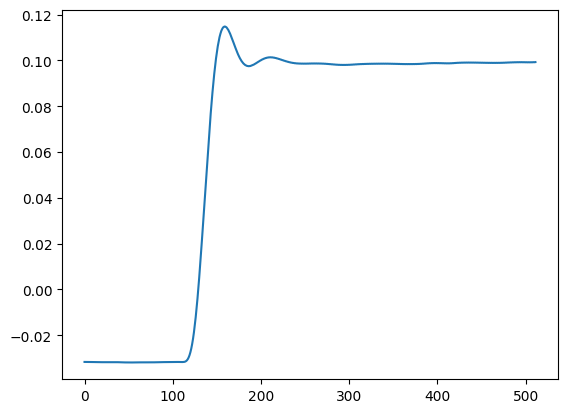

In [18]:
# sanity check
shape_rawraw = np.shape(rawraw)
seepl = np.reshape(rawraw, (-1, shape_rawraw[1]))

whatishere =slice_average_offset(
                    seepl,
                    (idx_av_0, idx_av_1),
                    (idx_bg_0, idx_bg_1),
                )
seepl  = np.mean(seepl, axis=0)
plt.plot(seepl)

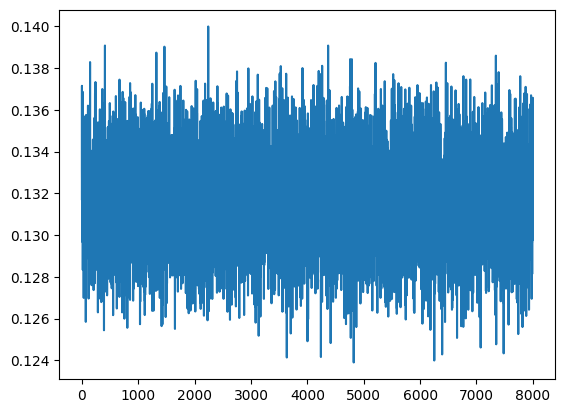

In [19]:
plt.plot(whatishere)

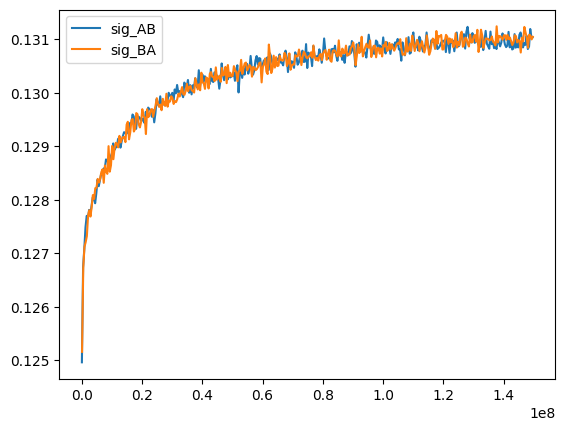

In [20]:
# import matplotlib.pyplot as plt
def sum_n(signal, n_avg):
    """
    Sums a signal array over every n_avg elements, as shown in the example.

    Args:
        signal (list or np.ndarray): The input signal array of numbers.
        n_avg (int): The number of elements to sum over in each chunk.

    Returns:
        list: A new list containing the summed values.
    """
    return [np.mean(signal[i:i+n_avg]) for i in range(0, len(signal), n_avg)]

tau_AB = dataset["tau_AB"]
tau_BA = dataset["tau_BA"]
sig_AB = dataset["sig_AB"]
sig_BA = dataset["sig_BA"]
n_avg = 8
# tau_AB = sum_n(tau_AB, 4)
# tau_BA = sum_n(tau_BA, 4)
# sig_AB = sum_n(sig_AB, 4)
# sig_BA = sum_n(sig_BA, 4)

tau_AB = tau_AB[::n_avg]
tau_BA = tau_BA[::n_avg]
sig_AB = sig_AB[::n_avg]
sig_BA = sig_BA[::n_avg]


plt.plot(tau_AB, sig_AB, label="sig_AB")
plt.plot(tau_BA, sig_BA, label="sig_BA")
# plt.plot(tau_AB, dataset["sig_AB_bg"], label="sig_AB_bg")
# plt.plot(tau_BA, dataset["sig_BA_bg"], label="sig_BA_bg")
plt.legend()
plt.show()


In [21]:
len(tau_AB)

375

## Filter out the charge dynamics


In [22]:
from scipy.optimize import curve_fit
def stretched_triple_exponential(t, A1, tau1, beta1, A2, tau2, beta2, A3, tau3, beta3, C):
    """
    Defines a triple stretched exponential function. This provides maximum
    flexibility for fitting complex multi-stage rise dynamics.

    Args:
        t (np.array): The time data.
        A1, A2, A3 (float): Amplitudes of the components.
        tau1, tau2, tau3 (float): Time constants of the components.
        beta1, beta2, beta3 (float): Stretch factors for each component.
        C (float): The vertical offset.

    Returns:
        np.array: The calculated values of the function.
    """
    component1 = A1 * (1 - np.exp(-(t / tau1)**beta1))
    component2 = A2 * (1 - np.exp(-(t / tau2)**beta2))
    component3 = A3 * (1 - np.exp(-(t / tau3)**beta3))
    return component1 + component2 + component3 + C

def filter_rising_background(time_data, signal_data):
    """
    Filters a signal by fitting a triple stretched exponential function to a
    corresponding background signal and subtracting the fit.

    Args:
        time_data (np.array): The array of time points for the signals.
        signal_data (np.array): The primary signal containing the oscillations
                                and the rising background.

    Returns:
        np.array: The filtered signal, with the rising trend removed.
        np.array: The fitted background curve.
    """
    # Initial guesses: [A1, tau1, beta1, A2, tau2, beta2, A3, tau3, beta3, C].
    total_amplitude = np.max(signal_data) - np.min(signal_data)
    initial_guesses = [
        total_amplitude * 0.53, 1e6, 1.0,  # Component 1 (fast)
        total_amplitude * 0.23, 2e7, 1.0,  # Component 2 (medium)
        total_amplitude * 0.23, 1e8, 1.0,  # Component 3 (slow)
        np.min(signal_data)            # C
    ]
    
    # Define bounds for the parameters. Constrain beta between 0 and 1.
    lower_bounds = [0, 0, 0, 0, 0, 0, 0, 0, 0, -np.inf]
    upper_bounds = [np.inf, np.inf, 3.0, np.inf, np.inf, 3.0, np.inf, np.inf, 3.0, np.inf]
    bounds = (lower_bounds, upper_bounds)

    try:
        popt, pcov = curve_fit(
            stretched_triple_exponential, 
            time_data, 
            signal_data, 
            p0=initial_guesses, 
            bounds=bounds,
            maxfev=30000, # Increased iterations for a very complex fit
            # method="trf"
        )
        
        print("Fit successful. Parameters:")
        print(f"  A1={popt[0]:.4f}, tau1={popt[1]:.2e}, beta1={popt[2]:.3f}")
        print(f"  A2={popt[3]:.4f}, tau2={popt[4]:.2e}, beta2={popt[5]:.3f}")
        print(f"  A3={popt[6]:.4f}, tau3={popt[7]:.2e}, beta3={popt[8]:.3f}")
        print(f"  C={popt[9]:.4f}")

        fitted_background = stretched_triple_exponential(time_data, *popt)
        filtered_signal = signal_data - fitted_background
        
        return filtered_signal, fitted_background

    except RuntimeError as e:
        print(f"Error: Curve fitting failed. {e}")
        return None, None



Fit successful. Parameters:
  A1=0.0029, tau1=1.69e+05, beta1=0.676
  A2=0.0037, tau2=1.68e+07, beta2=0.645
  A3=0.0009, tau3=1.00e+08, beta3=0.501
  C=0.1239
Fit successful. Parameters:
  A1=0.0082, tau1=8.07e+04, beta1=0.277
  A2=0.0020, tau2=1.86e+07, beta2=0.948
  A3=0.0012, tau3=8.66e+07, beta3=1.045
  C=0.1198


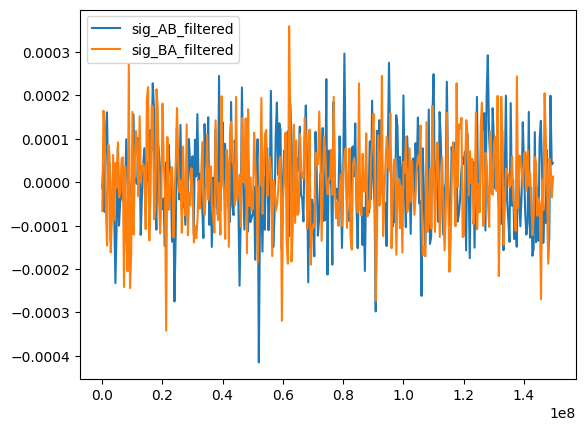

In [23]:
sig_AB_filtered, sig_AB_subtrate = filter_rising_background(tau_AB, sig_AB)
sig_BA_filtered, sig_BA_subtrate = filter_rising_background(tau_BA, sig_BA)

plt.plot(tau_AB, sig_AB_filtered, label="sig_AB_filtered")
plt.plot(tau_BA, sig_BA_filtered, label="sig_BA_filtered")

plt.legend()
plt.show()

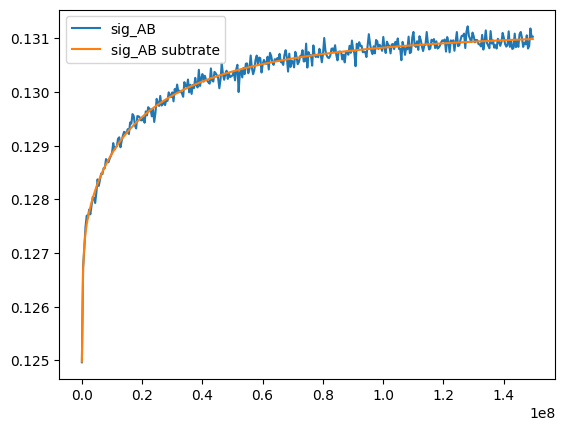

In [24]:
plt.plot(tau_AB, sig_AB, label="sig_AB")
plt.plot(tau_AB, sig_AB_subtrate, label="sig_AB subtrate")
plt.legend()
plt.show()

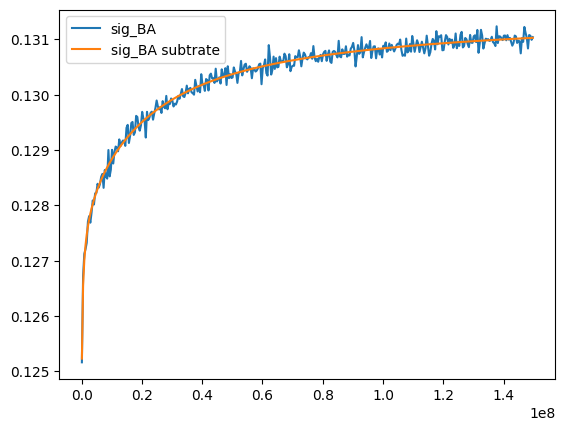

In [25]:
plt.plot(tau_BA, sig_BA, label="sig_BA")
plt.plot(tau_BA, sig_BA_subtrate, label="sig_BA subtrate")
plt.legend()
plt.show()

Applying sigmoid window for truncated FID...
Applying zero padding with factor x16...
Applying sigmoid window for truncated FID...
Applying zero padding with factor x16...


C:\Users\HFNV\AppData\Local\Temp\ipykernel_14936\484507847.py:148: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


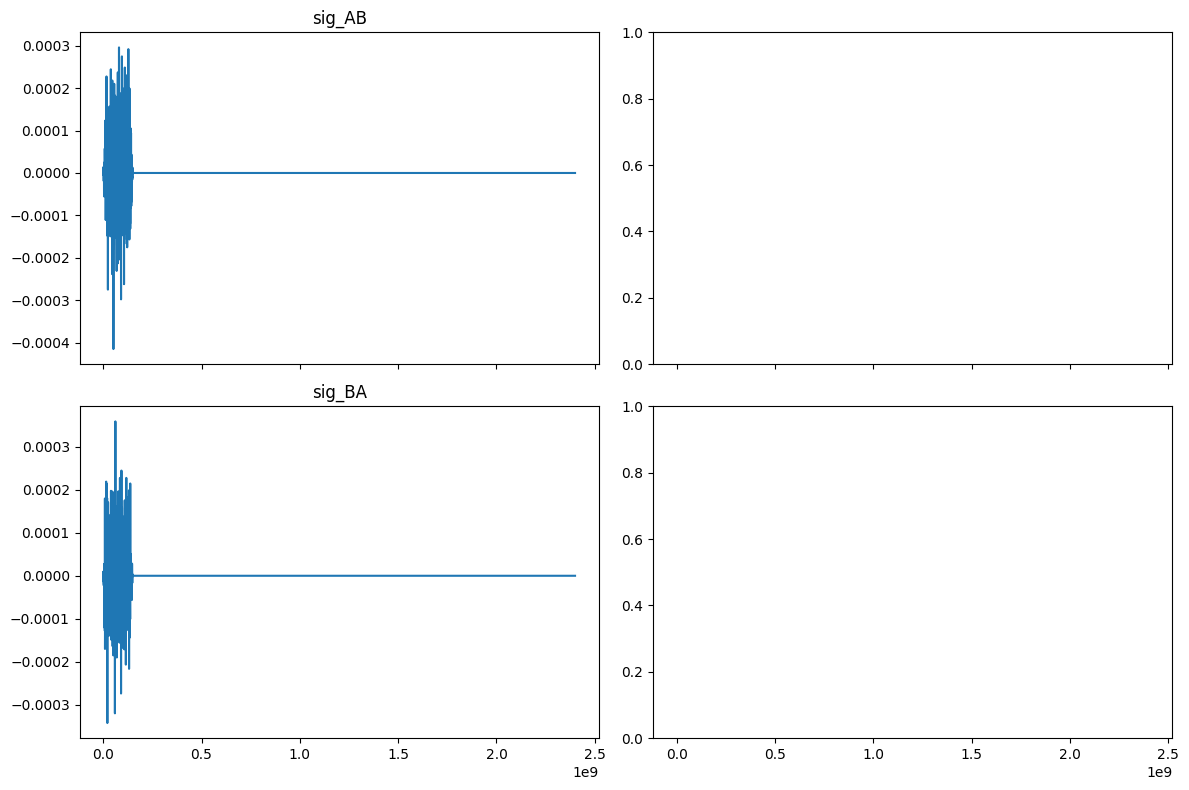

In [26]:
def apply_sine_bell_window(t, fid):
    """
    Applies a sine-bell window function to an FID.

    This is ideal for FIDs that are truncated (do not decay to zero by the
    end of the acquisition), as it smoothly tapers the signal to zero at
    both ends, preventing truncation artifacts (sinc wiggles) in the spectrum.

    Args:
        t (np.ndarray): The time vector for the FID in nanoseconds.
        fid (np.ndarray): The Free Induction Decay (time-domain signal).

    Returns:
        np.ndarray: The FID after applying the sine-bell window.
    """
    print("Applying sine-bell window for truncated FID...")
    n_points = len(fid)
    # Create a sine function that goes from 0 to pi over the acquisition time
    sine_window = np.sin(np.linspace(0, np.pi, n_points))
    
    windowed_fid = fid * sine_window
    return windowed_fid

def apply_sigmoid_window(t, fid, transition_ratio=0.1, steepness_param=6.0):
    """
    Applies a sigmoid window to both ends of an FID.

    This provides a very smooth taper to zero, which is useful for truncated
    FIDs. The shape of the taper can be controlled.

    Args:
        t (np.ndarray): The time vector for the FID in nanoseconds.
        fid (np.ndarray): The Free Induction Decay (time-domain signal).
        transition_ratio (float): Fraction of the signal at each end to apply
                                  the window to (e.g., 0.1 for 10%).
        steepness_param (float): Controls how sharp the sigmoid transition is.
                                 A value of 12 means the transition happens
                                 over a standard range for the exp function.
                                 Higher values make the transition sharper.

    Returns:
        np.ndarray: The FID after applying the sigmoid window.
    """
    print("Applying sigmoid window for truncated FID...")
    n_points = len(fid)
    transition_points = int(n_points * transition_ratio)

    # If the signal is too short or ratio is zero, don't apply a window.
    if transition_points == 0:
        return fid

    # Create the sigmoid transition shape for one edge
    x = np.linspace(-steepness_param / 2, steepness_param / 2, transition_points)
    sigmoid_curve = 1 / (1 + np.exp(-x))

    # Create the full window shape
    window = np.ones(n_points)
    # Apply the rising edge
    window[:transition_points] = sigmoid_curve
    # Apply the falling edge (the reversed sigmoid curve)
    window[-transition_points:] = sigmoid_curve[::-1]

    windowed_fid = fid * window
    return windowed_fid

def apply_apodization(t, fid, lb):
    """
    Applies an exponential decay function (apodization) to an FID.

    Args:
        t (np.ndarray): The time vector for the FID in nanoseconds.
        fid (np.ndarray): The Free Induction Decay (time-domain signal).
        lb (float): The line broadening factor in Hz for the exponential decay.

    Returns:
        np.ndarray: The FID after apodization.
    """
    # This multiplies the FID by a decaying exponential function to improve
    # the signal-to-noise ratio, at the cost of slightly broader lines.
    # The units of lb (GHz) and t (ns) are inverse, so their product is dimensionless.
    print(f"Applying exponential decay with LB = {lb} Hz...")
    lb_ghz = lb*1E-9
    decay_function = np.exp(-(lb_ghz * t)**1)
    apodized_fid = fid * decay_function
    return apodized_fid

def apply_zero_padding(t, fid, zero_padding_factor):
    """
    Applies zero padding to an FID.

    Args:
        t (np.ndarray): The time vector for the FID in nanoseconds.
        fid (np.ndarray): The FID to be padded.
        zero_padding_factor (int): The factor by which to increase the signal
                                   length (e.g., 2 for doubling).

    Returns:
        tuple: A tuple containing:
            - padded_fid (np.ndarray): The FID extended with zeros.
            - padded_t (np.ndarray): The new time vector for the padded FID in ns.
    """
    # This extends the FID with zeros to increase the number of points in the
    # resulting spectrum, making it appear smoother.
    print(f"Applying zero padding with factor x{zero_padding_factor}...")
    original_n_points = len(fid)
    new_n_points = original_n_points * zero_padding_factor
    
    # Create an array for the padded FID
    padded_fid = np.zeros(new_n_points, dtype=fid.dtype)
    # Copy the original FID into the beginning of the new array
    padded_fid[:original_n_points] = fid
    
    # Calculate the time step from the input time vector
    dt = t[1] - t[0]
    
    # Create the new time vector corresponding to the padded signal
    padded_t = np.arange(0, new_n_points * dt, dt)

    return padded_t, padded_fid

decay_apod = 0.5*1E9/(tau_AB[-1]-tau_BA[0])
# decay_apod = 10.0
factor_zp = 16

# sig_AB_ac = sig_AB - np.mean(sig_AB[int(len(sig_AB)*0.2):int(len(sig_AB)*0.8)])
sig_AB_ac = sig_AB_filtered
# sig_AB_zp_ap = sig_AB_ac
sig_AB_zp_ap = apply_sigmoid_window(tau_AB, sig_AB_ac)
# sig_AB_zp_ap = apply_apodization(tau_AB, sig_AB_ac, decay_apod)
tau_AB_zp_ap, sig_AB_zp_ap = apply_zero_padding(tau_AB, sig_AB_zp_ap, factor_zp)

# sig_BA_ac = sig_BA - np.mean(sig_BA)
sig_BA_ac = sig_BA_filtered
# sig_BA_zp_ap = sig_BA_ac
sig_BA_zp_ap = apply_sigmoid_window(tau_BA, sig_BA_ac)
# sig_BA_zp_ap = apply_apodization(tau_BA, sig_BA_ac, decay_apod)
tau_BA_zp_ap, sig_BA_zp_ap = apply_zero_padding(tau_BA, sig_BA_zp_ap, factor_zp)


# Plot the zero-padded FIDs
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True)
ax[0, 0].plot(tau_AB_zp_ap, sig_AB_zp_ap)
ax[0, 0].set_title("sig_AB")
ax[1, 0].plot(tau_BA_zp_ap, sig_BA_zp_ap)
ax[1, 0].set_title("sig_BA")

fig.tight_layout()
fig.show()


In [269]:
def calculate_snr(spec, dc_offset_pts=50, fwhm_factor_signal=2.0, fwhm_factor_noise=5.0):
    """
    Calculates the Signal-to-Noise Ratio (SNR) from a phased spectrum.

    This function implements a method based on integrating the signal and the
    noise power in regions defined relative to the main peak's linewidth.

    Args:
        spec (np.ndarray): A complex 1D numpy array of the phased NMR spectrum.
        dc_offset_pts (int): Number of points at the start and end of the
                             spectrum to ignore to avoid DC/filter artifacts.
        fwhm_factor_signal (float): Multiplier for the FWHM to define the signal region.
        fwhm_factor_noise (float): Multiplier for the FWHM to define the noise window.

    Returns:
        float: The calculated Signal-to-Noise Ratio.
    """
    # 1. Work with the real, phased spectrum and remove DC/edge artifacts.
    real_spec = spec.real.copy()
    real_spec[:dc_offset_pts] = 0
    # real_spec[-dc_offset_pts:] = 0

    # 2. Find the strongest peak.
    peak_index = np.argmax(real_spec)
    peak_height = real_spec[peak_index]

    # 3. Estimate the Full Width at Half Maximum (FWHM).
    try:
        half_max = peak_height / 2.0
        left_hm_indices = np.where(real_spec[:peak_index] < half_max)[0]
        left_hm_index = left_hm_indices[-1] if len(left_hm_indices) > 0 else 0

        right_hm_indices = np.where(real_spec[peak_index:] < half_max)[0]
        right_hm_index = (right_hm_indices[0] + peak_index) if len(right_hm_indices) > 0 else len(real_spec)
        
        fwhm = right_hm_index - left_hm_index
        if fwhm <= 0: 
            fwhm = 2  # Failsafe for very sharp or noisy peaks
    except IndexError:
        fwhm = 2 # Failsafe if peak finding fails
    # fwhm = 2 # Failsafe if peak finding fails
    # 4. Define signal and noise regions based on FWHM.
    signal_width = max(2, int(fwhm * fwhm_factor_signal))
    signal_start = max(0, peak_index - signal_width // 2)
    signal_end = min(len(real_spec), peak_index + signal_width // 2)

    noise_width = int(fwhm * fwhm_factor_noise)
    signal_noise_start = max(0, peak_index - noise_width//4)
    signal_noise_end = min(len(real_spec), peak_index + noise_width//4)
    noise_window_start = max(0, peak_index - noise_width // 2)
    noise_window_end = min(len(real_spec), peak_index + noise_width // 2)

    # 5. Get signal and noise data, excluding the signal region from the noise calculation.
    signal_data = real_spec[signal_start:signal_end]
    noise_data_left = real_spec[noise_window_start:signal_noise_start]
    noise_data_right = real_spec[signal_noise_end:noise_window_end]
    noise_data = np.concatenate((noise_data_left, noise_data_right))

    if len(noise_data) < 1:
        return 0.0 # Not enough data to calculate noise

    # Perform a local baseline correction based on the median of the noise.
    # baseline_level = np.median(noise_data)
    # signal_data_corrected = signal_data - baseline_level
    # noise_data_corrected = noise_data - baseline_level

    signal_data_corrected = signal_data
    noise_data_corrected = noise_data

    # 6. Integrate signal and noise power as per the specified method.
    signal_integral = np.mean(signal_data_corrected**2)
    signal_level = np.sqrt(signal_integral)
    # "take the square first then integrate"
    noise_power_integral = np.mean(noise_data_corrected**2)
    
    # "if they are squared, take the square root"
    noise_level = np.sqrt(noise_power_integral)
    
    # 7. Calculate SNR.
    if noise_level == 0:
        return np.inf  # Avoid division by zero for noiseless data

    snr = signal_level / noise_level
    
    # "multiple the value by 1/sqrt(2) to reduce the overestimation"
    snr_corrected = snr / np.sqrt(2)

    return snr_corrected

from scipy.optimize import minimize
from scipy.optimize import fmin
# --- Define a helper function for FFT calculation ---
def calculate_fft_abs(signal_avg, tau_array, DCfilter=True):
    N = len(signal_avg)
    try:
        T = tau_array[1] - tau_array[0]  # Sample spacing
    except IndexError:
        print("Warning: tau_array might not have enough points to determine sample spacing. Assuming T=1.")
        T = 1.0  # Default to 1 if not enough points

    # Remove DC component (mean) before FFT
    if DCfilter:
        yf = np.fft.fft(signal_avg - np.mean(signal_avg))
    else:
        yf = np.fft.fft(signal_avg)
    xf = np.fft.fftfreq(N, T)[:N//2] * 1e9 

    # Amplitude normalization
    amplitude = 2.0/N * np.abs(yf[0:N//2]) * 1E3 #mV
    return xf, amplitude

# --- Define a helper function for FFT calculation ---
def calculate_fft(signal_avg, tau_array, DCfilter=True):
    N = len(signal_avg)
    try:
        T = tau_array[1] - tau_array[0]  # Sample spacing
    except IndexError:
        print("Warning: tau_array might not have enough points to determine sample spacing. Assuming T=1.")
        T = 1.0  # Default to 1 if not enough points

    # Remove DC component (mean) before FFT
    if DCfilter:
        yf = np.fft.fft(signal_avg - np.mean(signal_avg))
    else:
        yf = np.fft.fft(signal_avg)
    xf = np.fft.fftfreq(N, T)[:N//2] * 1e9 

    # Amplitude normalization
    yf = 2.0/N * yf[0:N//2] * 1E3 #mV
    return xf, yf

# def auto_phase(spec, p0_guess=0.0, p1_guess=0.0, fwhm_factor_signal=1.0):
#     """
#     Automatically phases a 1D NMR spectrum.

#     This function finds the zero-order (p0) and first-order (p1) phase 
#     corrections that minimize the negative area of the real part of the spectrum,
#     focusing on a window around the tallest peak.

#     Args:
#         spec (np.ndarray): A complex 1D numpy array representing the NMR spectrum
#                            (the result of an FFT on the FID).
#         p0_guess (float): Initial guess for the zero-order phase in degrees.
#         p1_guess (float): Initial guess for the first-order phase in degrees.
#         fwhm_factor_signal (float): Multiplier for the FWHM to define the signal region.

#     Returns:
#         tuple: A tuple containing:
#             - np.ndarray: The phased spectrum (complex).
#             - float: The optimized zero-order phase (p0) in degrees.
#             - float: The optimized first-order phase (p1) in degrees.
#     """
    
#     # --- Find the region of interest around the tallest peak ---
#     # This makes the phasing more robust to noise and baseline issues
#     # far away from the main signals.
#     dc_offset_pts = int(len(spec)*0.10)
#     specabs = np.abs(spec)
#     peak_index = np.argmax(specabs[dc_offset_pts:])
#     peak_height = specabs[peak_index]
#     # print(peak_index)
#     # print(f"peak height: {peak_height}")

#     #  Estimate the Full Width at Half Maximum (FWHM).
#     try:
#         half_max = peak_height / 2.0
#         # print(np.abs(spec)[:peak_index])
#         left_hm_indices = np.where((specabs[:peak_index]) < half_max)[0]
#         left_hm_index = left_hm_indices[-1] if len(left_hm_indices) > 0 else 0
#         # print(f"left hm index s: {left_hm_indices}")
#         # print(f"left hm index: {left_hm_index}")
#         right_hm_indices = np.where((specabs[peak_index:])  < half_max)[0]
#         right_hm_index = (right_hm_indices[0] + peak_index) if len(right_hm_indices) > 0 else len(spec)
#         # print(f"right hm index: {right_hm_index}")
#         fwhm = right_hm_index - left_hm_index
#         # print(f"FWHM = {fwhm}")
#         if fwhm <= 0: 
#             fwhm = 2  # Failsafe for very sharp or noisy peaks
#     except IndexError:
#         fwhm = 2 # Failsafe if peak finding fails
#     # fwhm = 2 # Failsafe if peak finding fails
#     # 4. Define signal and noise regions based on FWHM.
#     window_pts = max(2, int(fwhm * fwhm_factor_signal))
#     # print(window_pts)
#     half_window = window_pts // 2
#     start_index = max(0, peak_index - half_window)
#     end_index = min(len(spec), peak_index + half_window)



#     # --- Helper function to apply phase correction ---
#     def apply_phase(p, s):
#         """Applies phase correction to a spectrum."""
#         p0 = np.deg2rad(p[0])  # Zero-order phase in radians
#         p1 = np.deg2rad(p[1])  # First-order phase in radians
        
#         # Create a linear ramp for the first-order correction
#         # This ramp is centered, so the pivot point for p1 is the center of the spectrum
#         size = len(s)
#         ramp = np.linspace(-size / 2, size / 2, size)
        
#         # Apply the phase correction
#         phased_spec = s * np.exp(1j * (p0 + p1 * ramp))
#         return phased_spec

#     # # --- Cost function for the optimization ---
#     # def cost_function(p, s):
#     #     """
#     #     Calculates the 'cost' of a given phase correction.
#     #     The cost is the sum of the absolute values of the negative points
#     #     in the real part of the phased spectrum, calculated only within
#     #     the specified window.
#     #     """
#     #     phased_spec = apply_phase(p, s)
        
#     #     # We only care about the real part for the final spectrum
#     #     real_spec = phased_spec.real
        
#     #     # Focus on the window around the main peak
#     #     windowed_real_spec = real_spec[start_index:end_index]
        
#     #     # Penalize negative points within the window
#     #     cost = np.sum(np.abs(windowed_real_spec[windowed_real_spec < 0]))

#     #     return cost

#     # --- Cost function for the optimization ---
#     def cost_function_imag(p, s):
#         """
#         Calculates the cost of a given phase correction within the defined window.

#         The cost is the sum of the squares of the negative points in the
#         real part plus the sum of the squares of all points in the imaginary part.
#         """
#         # Apply the current phase parameters
#         phased_spec = apply_phase(p, s)
        
#         # Slice the spectrum to focus on the window around the main peak
#         windowed_spec = phased_spec[start_index:end_index]

#         # real_part = windowed_spec.real
#         imag_part = windowed_spec.imag
        
#         # Calculate the penalty for the real part within the window
#         # cost_real = np.sum(real_part[real_part < 0]**2)
#         # cost_real = np.sum(real_part[real_part > 0]**2)
        
#         # Calculate the penalty for the imaginary part within the window
#         # cost_imag = np.sum(imag_part**2)
#         cost_imag = np.sum((imag_part[1:]-imag_part[:-1])**2+(imag_part[:-1]-imag_part[1:])**2)
        
#         return -cost_imag

#     # --- Cost function for the optimization ---
#     def cost_function_real(p, s):
#         """
#         Calculates the cost of a given phase correction within the defined window.

#         The cost is the sum of the squares of the negative points in the
#         real part plus the sum of the squares of all points in the imaginary part.
#         """
#         # Apply the current phase parameters
#         phased_spec = apply_phase(p, s)
        
#         # Slice the spectrum to focus on the window around the main peak
#         windowed_spec = phased_spec[start_index:end_index]

#         real_part = windowed_spec.real
    
#         # Calculate the penalty for the real part within the window
#         # cost_real = np.sum(real_part[real_part < 0]**2)
#         cost_real = np.sum(np.abs(real_part[real_part < 0]))

#         return cost_real
    
#     def cost_function(p, s):
#         """
#         Calculates the cost of a given phase correction within the defined window.

#         The cost is the sum of the squares of the negative points in the
#         real part plus the sum of the squares of all points in the imaginary part.
#         """
#         # Apply the current phase parameters
#         phased_spec = apply_phase(p, s)
        
#         # Slice the spectrum to focus on the window around the main peak
#         windowed_spec = phased_spec[start_index:end_index]

#         real_part = windowed_spec.real
#         imag_part = windowed_spec.imag
        
#         # Calculate the penalty for the real part within the window
#         cost_real = np.sum(real_part[real_part < 0]**2)

        
#         # Calculate the penalty for the imaginary part within the window
#         cost_imag = np.sum(imag_part**2)

        
#         return cost_imag + cost_real
    
#     # --- Optimization ---
#     # Use scipy.optimize.minimize to find the phase values (p0, p1)
#     # that result in the minimum value of the cost function.
#     p_initial_guess = [p0_guess, p1_guess]
    
#     # The 'Nelder-Mead' method is a robust choice for this kind of problem.
#     result = minimize(cost_function_imag, p_initial_guess, args=(spec,), method='Nelder-Mead')
    
#     p_optimized_imag = result.x
#     score_imag = result.fun

#     result = minimize(cost_function_real, p_initial_guess, args=(spec,), method='Nelder-Mead')
#     p_optimized_real = result.x
#     score_real = result.fun
    
#     p_optimized = p_optimized_real if score_real < score_imag else p_optimized_imag
#     result = minimize(cost_function, p_optimized, args=(spec,), method='Nelder-Mead')
#     # print(result)
#     p_optimized = result.x
#     p0_opt, p1_opt = p_optimized[0], p_optimized[1]


#     # Apply the final, optimized phase correction
#     final_phased_spec = apply_phase(p_optimized, spec)
    
#     return final_phased_spec, p0_opt, p1_opt

from scipy.optimize import minimize, basinhopping

def auto_phase(spec, fwhm_factor_signal=0.25, p1_limit=0.0):
    """
    Automatically phases a 1D NMR spectrum using a two-step optimization process.

    This function first uses a fast grid search to find an approximate solution
    for the zero-order (p0) and first-order (p1) phase corrections. It then
    refines this solution using a local minimizer (Nelder-Mead). The optimization
    aims to minimize negative components in the real part and minimize the overall
    area of the imaginary part of the spectrum, focusing on a window around the
    tallest peak.

    Args:
        spec (np.ndarray): A complex 1D numpy array representing the NMR spectrum
                           (the result of an FFT on the FID).
        p0_guess (float): Initial guess for the zero-order phase in degrees.
        p1_guess (float): Initial guess for the first-order phase in degrees.
        fwhm_factor_signal (float): Multiplier for the FWHM to define the signal region.

    Returns:
        tuple: A tuple containing:
            - np.ndarray: The phased spectrum (complex).
            - float: The optimized zero-order phase (p0) in degrees.
            - float: The optimized first-order phase (p1) in degrees.
    """

    # --- Find the region of interest around the tallest peak ---
    # This makes phasing more robust by focusing on signal, not noise/baseline.
    # Ignore the first 10% of points which might contain DC artifacts.
    dc_offset_pts = int(len(spec) * 0.10)
    spec_real_abs = np.abs(spec.real)
    
    # Find peak in the relevant region
    peak_index_offset = np.argmax(spec_real_abs[dc_offset_pts:])
    peak_index = peak_index_offset + dc_offset_pts
    peak_height = spec_real_abs[peak_index]

    # --- Estimate the Full Width at Half Maximum (FWHM) ---
    try:
        half_max = peak_height / 2.0
        
        # Find left and right points where the signal drops to half maximum
        left_hm_indices = np.where(spec_real_abs[:peak_index] < half_max)[0]
        left_hm_index = left_hm_indices[-1] if len(left_hm_indices) > 0 else 0
        
        right_hm_indices = np.where(spec_real_abs[peak_index:] < half_max)[0]
        right_hm_index = (right_hm_indices[0] + peak_index) if len(right_hm_indices) > 0 else len(spec)
        
        fwhm = right_hm_index - left_hm_index
        if fwhm <= 0:
            fwhm = 2  # Failsafe for very sharp or noisy peaks
    except IndexError:
        fwhm = 2  # Failsafe if peak finding fails

    # --- Define signal window based on FWHM ---
    window_pts = max(2, int(fwhm * fwhm_factor_signal))
    half_window = window_pts // 2
    start_index = max(0, peak_index - half_window)
    end_index = min(len(spec), peak_index + half_window)

    # --- Helper function to apply phase correction ---
    def apply_phase(p, s):
        """Applies phase correction to a spectrum."""
        p0 = np.deg2rad(p[0])  # Zero-order phase in radians
        p1 = np.deg2rad(p[1])  # First-order phase in radians
        # p1 = 0
        # Create a linear ramp for the first-order correction, centered at the peak
        size = len(s)
        ramp = np.linspace(0, size, size)
        ramp -= ramp[peak_index]
        
        # Apply the phase correction using complex exponential
        phased_spec = s * np.exp(1j * (p0 + p1 * ramp))
        return phased_spec

    # --- Cost functions for the optimization ---
    def cost_function_imag(p, s):
        """
        Calculates cost based on the imaginary part of the spectrum.
        A flatter imaginary baseline (smaller derivatives) is better.
        """
        phased_spec = apply_phase(p, s)
        windowed_spec = phased_spec[start_index:end_index]
        imag_part = windowed_spec.imag
        # Penalize non-flatness in the imaginary part
        cost = -np.sum((imag_part[1:] - imag_part[:-1])**2+(imag_part[-1:] - imag_part[1:])**2)
        return cost

    def cost_function_real(p, s):
        """
        Calculates cost based on the real part of the spectrum.
        Penalizes negative points, aiming for a positive-only spectrum.
        """
        phased_spec = apply_phase(p, s)
        windowed_spec = phased_spec[start_index:end_index]
        real_part = windowed_spec.real
        # Penalize any negative amplitude in the real part
        cost = np.sum(np.abs(real_part[real_part < 0]))
        return cost

    def cost_function(p, s):
        """
        Combined cost function for final local optimization.
        It penalizes both negative real parts and the total area of the imaginary part.
        """
        phased_spec = apply_phase(p, s)
        windowed_spec = phased_spec[start_index:end_index]
        real_part = windowed_spec.real
        imag_part = windowed_spec.imag
        
        # Penalty for negative points in the real part
        cost_real = np.sum(real_part[real_part < 0]**2)
        # Penalty for any signal in the imaginary part
        cost_imag = np.sum((imag_part)**2)
        
        return cost_imag + cost_real

    # --- Two-Step Optimization ---
    
    # STEP 1: Fast global search using a coarse grid
    print("Starting global grid search...")
    p0_range = np.arange(0.5, 360.5, 45) # Search p0 from 0-360 in steps of 20
    
    best_score_real = float('inf')
    best_p_real = [0, 0]
    
    best_score_imag = float('inf')
    best_p_imag = [0, 0]

    for p0_val in p0_range:
        p_current = [p0_val, 0]
        
        # Evaluate real cost
        score_r = cost_function_real(p_current, spec)
        if score_r < best_score_real:
            best_score_real = score_r
            best_p_real = p_current

        # Evaluate imaginary cost
        score_i = cost_function_imag(p_current, spec)
        if score_i < best_score_imag:
            best_score_imag = score_i
            best_p_imag = p_current

    # Determine which grid search gave a better result by evaluating
    # with the combined cost function.
    score_from_real_opt = cost_function(best_p_real, spec)
    score_from_imag_opt = cost_function(best_p_imag, spec)

    p_global_best = best_p_real if score_from_real_opt < score_from_imag_opt else best_p_imag
    print(f"Global search complete. Best guess: p0={p_global_best[0]:.2f}, p1={p_global_best[1]:.2f}")

    # STEP 2: Local search using the best result from the global search
    # This fine-tunes the parameters for a precise solution.
    print("Starting local optimization...")
    # Define bounds for the optimization. p0 is unbounded, p1 is limited.

    bounds = [(None, None), (- 0.000,  0.000)]
    final_result = minimize(
        cost_function,
        p_global_best,
        args=(spec,),
        method='Nelder-Mead',
        bounds=bounds
    )

    bounds = [(None, None), (-p1_limit, p1_limit)]
    final_result = minimize(
        cost_function,
        final_result.x,
        args=(spec,),
        method='Nelder-Mead',
        bounds=bounds
    )

    # p0_limit = 0.001
    # p1_limit = 180.0
    # bounds = [(-p0_limit, p0_limit), (-p1_limit, p1_limit)]
    # final_result = minimize(
    #     cost_function,
    #     final_result.x,
    #     args=(spec,),
    #     method='Nelder-Mead',
    #     bounds=bounds
    # )

    p_optimized = final_result.x
    p0_opt, p1_opt = p_optimized[0], p_optimized[1]
    print(f"Optimization complete. Best guess: p0={p_optimized[0]:.2f}, p1={p_optimized[1]:.2f}")

    # Apply the final, optimized phase correction
    final_phased_spec = apply_phase(p_optimized, spec)
    
    return final_phased_spec, p0_opt, p1_opt

In [284]:


tau_AB_origin = dataset["tau_AB"]
tau_BA_origin = dataset["tau_BA"]
sig_AB_origin = dataset["sig_AB"]
sig_BA_origin = dataset["sig_BA"]
n_avg = 1
amp_df = 0.0
amp_df_raw = 0.0
amp_df_phased = 0.0
amp_df_phased_anti= 0.0
for ii in range(n_avg):
    tau_AB = tau_AB_origin[ii::n_avg]
    tau_BA = tau_BA_origin[ii::n_avg]
    sig_AB = sig_AB_origin[ii::n_avg]
    sig_BA = sig_BA_origin[ii::n_avg]
    # filter out the decay dynamics
    sig_AB_filtered, sig_AB_subtrate = filter_rising_background(tau_AB, sig_AB)
    sig_BA_filtered, sig_BA_subtrate = filter_rising_background(tau_BA, sig_BA)

    # perform apodization and zero filling
    decay_apod = 0.5*1E9/(tau_AB[-1]-tau_AB[0])
    factor_zp = 16

    sig_AB_ac = sig_AB_filtered
    sig_AB_zp_ap = apply_sigmoid_window(tau_AB, sig_AB_ac)
    tau_AB_zp_ap, sig_AB_zp_ap = apply_zero_padding(tau_AB, sig_AB_zp_ap, factor_zp)

    sig_BA_ac = sig_BA_filtered
    sig_BA_zp_ap = apply_sigmoid_window(tau_BA, sig_BA_ac)
    tau_BA_zp_ap, sig_BA_zp_ap = apply_zero_padding(tau_BA, sig_BA_zp_ap, factor_zp)


    # Calculate FFT for both signals
    xf_AB, amp_AB = calculate_fft(sig_AB_zp_ap, tau_AB_zp_ap, DCfilter=False)
    xf_BA, amp_BA = calculate_fft(sig_BA_zp_ap, tau_BA_zp_ap, DCfilter=False)

    # amp_AB_df = amp_AB
    # amp_BA_df = amp_BA

    # amp_df = np.abs((amp_AB_df+amp_BA_df)/2.0)
    amp_df += np.abs(amp_AB) + np.abs(amp_BA)
    # amp_df += amp_AB + amp_BA
    # amp_df_norm = amp_df/np.max(amp_df[len(amp_df)//2:])

    xf_AB_raw, amp_AB_raw = calculate_fft(sig_AB, tau_AB, DCfilter=True)
    xf_BA_raw, amp_BA_raw = calculate_fft(sig_BA, tau_BA, DCfilter=True)

    amp_AB_df_raw = amp_AB_raw
    amp_BA_df_raw = amp_BA_raw
    amp_df_raw += np.abs(amp_AB_df_raw)+np.abs(amp_BA_df_raw)/2.0
    # amp_df_raw += np.abs((amp_AB_df_raw+amp_BA_df_raw)/2.0)
    # amp_df_raw += amp_AB_raw+amp_BA_raw
    # amp_df_raw_norm = amp_df_raw/np.max(amp_df_raw[len(amp_df_raw)//2:])

    # Phase correction to each spectrum
    amp_AB_modi = amp_AB
    amp_BA_modi = amp_BA
    fwhm_factor = 0.1
    p1_limit = 0.0
    amp_AB_df_phased, p0_AB, p1_AB = auto_phase(amp_AB_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_AB_df_phased_neg, p0_AB, p1_AB = auto_phase(-amp_AB_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_BA_df_phased, p0_BA, p1_BA = auto_phase(amp_BA_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_BA_df_phased_neg, p0_BA, p1_BA = auto_phase(-amp_BA_modi, fwhm_factor_signal=fwhm_factor, p1_limit=p1_limit)
    amp_df_phased += amp_AB_df_phased+amp_BA_df_phased
    amp_df_phased_anti += amp_AB_df_phased+amp_BA_df_phased+amp_AB_df_phased_neg+amp_BA_df_phased_neg

amp_df = np.abs(amp_df)
amp_df_norm = amp_df/np.max(amp_df[int(len(amp_df)*0.2):])
amp_df_raw = np.abs(amp_df_raw)
amp_df_raw_norm = amp_df_raw/np.max(amp_df_raw[int(len(amp_df_raw)*0.2):])
# amp_df_raw_norm[:int(len(amp_df_raw)*0.2)]=0

amp_df_phased = amp_df_phased/np.max(amp_df_phased.real)
amp_df_phased_anti = amp_df_phased_anti/np.max(amp_df_phased_anti.real)
a = 0.4
b = 0.6
amp_df_combined = (a*amp_df_norm+b*amp_df_phased.real)/(a+b)
amp_df_combined_anti = (a*amp_df_norm+b*amp_df_phased_anti.real)/(a+b)


# --- Plotting with Plotly ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplots for time domain and frequency domain
fig = make_subplots(rows=1, cols=1,
                    subplot_titles=('Averaged Signals (Time Domain)', 'FFT of Averaged Signals (Frequency Domain)'))



# Add frequency domain plots

fig.add_trace(go.Scatter(x=xf_AB_raw, y=amp_df_raw_norm, mode='lines', name='raw'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=amp_df_norm, mode='lines', name='filtered'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_phased.real), mode='lines', name='filtered phased'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_phased_anti.real), mode='lines', name='filter phased anti'),
              row=1, col=1)
# fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_combined), mode='lines', name='combine filter phased'),
#               row=1, col=1)
# fig.add_trace(go.Scatter(x=xf_AB, y=np.abs(amp_df_combined_anti), mode='lines', name='combine filter phased anti'),
#               row=1, col=1)

# Update layout for frequency domain plot
fig.update_xaxes(title_text='Frequency (Hz)', row=1, col=1) # Changed to MHz

fig.update_yaxes(title_text='Amplitude', row=1, col=1, range=[0, 1.1])


# Update overall layout
fig.update_layout(width=800, showlegend=True, hovermode="x unified")
fig.show()

Fit successful. Parameters:
  A1=0.0036, tau1=4.02e+05, beta1=0.414
  A2=0.0024, tau2=1.83e+07, beta2=0.921
  A3=0.0010, tau3=9.95e+07, beta3=1.153
  C=0.1242
Fit successful. Parameters:
  A1=0.0022, tau1=2.17e+05, beta1=0.907
  A2=0.0029, tau2=8.16e+06, beta2=0.669
  A3=0.0015, tau3=5.36e+07, beta3=1.034
  C=0.1244
Applying sigmoid window for truncated FID...
Applying zero padding with factor x16...
Applying sigmoid window for truncated FID...
Applying zero padding with factor x16...
Starting global grid search...
Global search complete. Best guess: p0=90.50, p1=0.00
Starting local optimization...
Optimization complete. Best guess: p0=163.87, p1=0.00
Starting global grid search...
Global search complete. Best guess: p0=0.50, p1=0.00
Starting local optimization...
Optimization complete. Best guess: p0=-16.13, p1=0.00
Starting global grid search...
Global search complete. Best guess: p0=0.50, p1=0.00
Starting local optimization...
Optimization complete. Best guess: p0=17.85, p1=0.00
Sta

In [286]:
fwhm_factor = 0.5
snr_raw = calculate_snr(amp_df_raw_norm, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_abssum = calculate_snr(amp_df_norm, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_phased = calculate_snr(amp_df_phased, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_phased_anti = calculate_snr(amp_df_phased_anti, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_combin = calculate_snr(amp_df_combined, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)
snr_combin_anti = calculate_snr(amp_df_combined_anti, dc_offset_pts=50, fwhm_factor_signal=fwhm_factor, fwhm_factor_noise=200.0)

print(f"SNR for signal raw:{snr_raw}")
print(f"SNR for signal abssum:{snr_abssum}")
print(f"SNR for signal phased:{snr_phased}")
print(f"SNR for signal phased_anti:{snr_phased_anti}")
print(f"SNR for signal combined:{snr_combin}")
print(f"SNR for signal combined anti:{snr_combin_anti}")

SNR for signal raw:4.287749594895831
SNR for signal abssum:9.176286547942206
SNR for signal phased:12.115962503453535
SNR for signal phased_anti:12.115965454852924
SNR for signal combined:14.061181097525626
SNR for signal combined anti:14.061182923449724
